In [ ]:
# if training on google collaborate
from google.colab import drive
drive.mount('/content/gdrive', force_remount= True)
%cd gdrive/MyDrive/Autism-Paper/autism-master

Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/1xjrNxPrG56lMdsRz8cjBGB9s6ruYpC8g/Autism-Paper/autism-master


In [ ]:
ls

ami_environment.yml        environment.yml  preprocessing/    submissions/
autism_starting_kit.ipynb  img/             problem.py        SVM_perm_test.eps
data/                      mini.sh          README.md         SVM_perm_test.pdf
download_data.py           ml_models/       requirements.txt  vae_nets/


# Helper

## Data Processing, Defining PyTorch Dataset and Transforms

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class PatientDataSet(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.data_columns = self.df.columns[0:len(df.columns)-1]
        self.target_column = self.df.columns[len(df.columns)-1]  #label
        self.transform = transform  #for adding noise and transform to pytorch

    def __len__(self):
        return len(self.df.index)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        selected_rows = self.df.iloc[idx]

        data = selected_rows[self.data_columns]
        diagnosis = selected_rows[self.target_column]
        index = selected_rows.index

        sample = {'data':data, 'diagnosis':diagnosis}

        if self.transform:
            sample = self.transform(sample)

        return sample

    def get_X(self):
        data = self.df[self.data_columns]
        return data

    def get_Y(self):
        diagnosis = self.df[self.target_column]
        return diagnosis

In [ ]:
class GaussianNoise:
    def __init__(self, mean, std_dev, data_columns):
        self.mean = mean
        self.std_dev = std_dev
        self.data_columns = data_columns

    def __call__(self, sample):
        shape = sample['data'][self.data_columns].shape
        noise = np.random.normal(self.mean, self.std_dev, shape)

        data = sample['data']
        data_noisy = data.copy()
        data_noisy[self.data_columns] += noise

        return {'data':data, 'data_noisy':data_noisy, 'diagnosis':sample['diagnosis']}

In [ ]:
class ToTorchFormat:
    def __call__(self, sample):
        data = sample['data'].astype('float64')
        data_formatted = torch.from_numpy(data.to_numpy()).float()
        diagnosis = sample['diagnosis'].astype('int64')
        diagnosis_formatted = torch.from_numpy(np.asarray(diagnosis))

        sample_new = {'data':data_formatted,
                      'diagnosis':diagnosis_formatted}
        if 'data_noisy' in sample.keys():
            data_noisy = sample['data_noisy'].astype('float64')
            data_noisy_formatted = torch.from_numpy(data_noisy.to_numpy()).float()
            sample_new['data_noisy'] = data_noisy_formatted

        return sample_new

In [ ]:
def split_df(df, **kwargs):  #not used in the Autism-Paper
  # split dateframe
    n_rows = kwargs.get('n_rows', None)
    randomize = kwargs.get('randomize', False)
    random_seed = kwargs.get('random_seed', None)
    train_test_split = kwargs.get('train_test_split', False)
    percent_split = kwargs.get('percent_split', None)
    validation_split = kwargs.get('validation_split', None)

    if n_rows:
        n_rows = min(n_rows, len(df.index)-1)

    if not randomize:
        if train_test_split:
            if percent_split:
                if n_rows:
                    split = int(percent_split*n_rows)
                    train_df = df.iloc[0:split]
                    test_df = df.iloc[split:n_rows]
                else:
                    split = int(percent_split*(len(df.index)-1))
                    train_df = df.iloc[0:split]
                    test_df = df.iloc[split:]
                if validation_split:
                    split = int(validation_split*(len(train_df.index)-1))
                    val_df = train_df.iloc[0:split]
                    train_df = train_df.iloc[split:]
            else:
                raise Exception("Wanted train test split, but no split was given. Must set 'percent_split' as an argument.")

            if not validation_split:
                return train_df, test_df
            else:
                return train_df, val_df, test_df

        else:
            if percent_split:
                if n_rows:
                    split = int(percent_split*n_rows)
                else:
                    split = int(percent_split*(len(df.index)-1))
                df = df.iloc[0:split]
            elif n_rows:
                df = df.iloc[0:nrows]

            return df

    else:
        if random_seed:
            np.random.seed(random_seed)

        if train_test_split:
            if percent_split:
                if n_rows:
                    split = int(percent_split*n_rows)
                    df_indices = np.random.choice(df.index, n_rows)
                else:
                    split = int(percent_split*(len(df.index)-1))
                    df_indices = np.random.choice(df.index, len(df.index))
                train_df = df.loc[df_indices[0:split]]
                test_df = df.loc[df_indices[split:]]

                if validation_split:
                    split = int(validation_split*(len(train_df.index)-1))
                    val_df = train_df.iloc[0:split]
                    train_df = train_df.iloc[split:]
            else:
                raise Exception("Wanted train test split, but no split was given. Must set 'percent_split' as an argument.")

            if not validation_split:
                return train_df, test_df
            else:
                return train_df, val_df, test_df

        else:
            if percent_split:
                if n_rows:
                    split = int(percent_split*n_rows)
                else:
                    split = int(percent_split*(len(df.index)-1))
                df_indices = np.random.choice(df.index, split)
                df = df.loc[df_indices]
            elif n_rows:
                df_indices = np.random.choice(df.index, n_rows)
                df = df.loc[df_indices]
            else:
                df_indices = np.random.choice(df.index, len(df.index))
                df = df.loc[df_indices]

            return df

In [ ]:
def generate_datasets(csv_path, **kwargs):
  # Generating PyTorch Datasets from Data
    dataset_type = kwargs.get('dataset_type', 'RS')
    non_data_cols = kwargs.get('non_data_cols', [])

    kwargs['cols_to_ignore'] = non_data_cols

    # if dataset_type == 'RS':
    #     df = load_corr_clinical(csv_path, **kwargs)
    # elif dataset_type == 'DTI':
    #     df = load_DTI(csv_path, **kwargs)
    # elif dataset_type == 'T1':
    #     df = load_T1(csv_path, **kwargs)
    # else:
    #     raise ValueError("Invalid argument {} for kwarg 'type'. Only accepts 'RS', 'DTI', or 'T1'".format(dataset_type))

    dfs = split_df(df, **kwargs)

    if type(dfs) is tuple:
        if len(dfs) == 2:
            train_dataset = PatientDataSet(dfs[0], dataset_type=dataset_type, non_data_cols=non_data_cols)
            test_dataset = PatientDataSet(dfs[1], dataset_type=dataset_type, non_data_cols=non_data_cols)
            return train_dataset, test_dataset
        elif len(dfs) == 3:
            train_dataset = PatientDataSet(dfs[0], dataset_type=dataset_type, non_data_cols=non_data_cols)
            val_dataset = PatientDataSet(dfs[1], dataset_type=dataset_type, non_data_cols=non_data_cols)
            test_dataset = PatientDataSet(dfs[2], dataset_type=dataset_type, non_data_cols=non_data_cols)
            return train_dataset, val_dataset, test_dataset
    else:
        return PatientDataSet(dfs, dataset_type=dataset_type, non_data_cols=non_data_cols)

## Tracking and Storing Model Performance

In [ ]:
import pickle
import os

In [ ]:
class Log:
    def __init__(self, log_name='log.txt', log_path = '.', should_log=True, overwrite=True):
        self.log_name = log_name
        self.log_path = log_path
        self.curr_str = ""
        self.total_str = ""
        self.should_log = should_log
        self.overwrite = overwrite

    def enable(self):

        self.should_log = True

    def disable(self):
        self.should_log = False

    def clear(self):
        self.curr_str = ""
        self.total_str = ""

    def set_name(self, name):
        self.log_name = name

    def set_path(self, path):
        self.log_path = path

    def get_log(self):
        return self.total_str

    def print_log(self):
        print(self.total_str)

    def save(self):
        if self.should_log:
            fpath = os.path.join(self.log_path, self.log_name)
            if self.overwrite:
                with open(fpath, 'w+') as logfile:
                    logfile.write(self.total_str)
            else:
                with open(fpath, 'a') as logfile:
                    logfile.write(self.curr_str)
                self.curr_str = ""

    def print_and_log(self, *args, **kwargs):
        if self.should_log:
            new_str= ""
            for s in args:
                new_str += str(s)
            new_str += '\n'
            self.curr_str += new_str
            self.total_str += new_str
            print(*args, **kwargs)
        else:
            print(*args, **kwargs)
            return None


class Stats:
    def __init__(self, filename='stats', path='.', load=True):
        # Want to ensure stats files have .stt extension
        fname, fext = os.path.splitext(filename)
        if fext != ".stt" and fext != "":
            raise Exception("Filename '{}' does not have correct extension ('{}' instead of '.stt')".format(filename, fext))
        if fext != ".stt":
            self.filename = fname + ".stt"

        self.path = path

        filepath = os.path.join(self.path, self.filename)

        if load and os.path.exists(filepath):
            with open(filepath, 'rb') as pickle_file:
                self.stats = pickle.load(pickle_file)
        else:
            if load:
                print("Warning: You are trying to load a stats file '{}' that doesn't exist.".format(os.path.abspath(filepath)))
            self.stats = {}

    def clear_stat(self, statname):
        if statname in self.stats:
            self.stats[statname] = {}

    def delete_stat(self, statname):
        del stats[statname]

    def track_stat(self, statname, key, val):
        if statname not in self.stats:
            self.stats[statname] = {}
        self.stats[statname][key] = val

    def set_name(self, name):
        self.filename = name

    def set_path(self, path):
        self.path = path

    def save(self):
        filepath = os.path.join(self.path, self.filename)
        with open(filepath, 'wb') as pickle_file:
            pickle.dump(self.stats, pickle_file)

    def __getitem__(self, key):
        return self.stats[key]

## Generating, Loading, and Storing Models

In [ ]:
import os
import warnings
import re

In [ ]:
# Network naming stuff
network_ext = '.nn'
network_name_fstr = '{}_{}' + network_ext

models_path = 'vae_nets'


def get_model_path(model_name):
    return os.path.join(models_path, model_name)


def make_model_path(model_name):

    path = get_model_path(model_name)
    if not os.path.exists(path):
        os.makedirs(path)
    return path


class NetworkMetadata:
    filename = 'netinfo.mtd'

    def __init__(self, model_name, input_size=None, hidden_size=None, latent_size=None, activations=None):
        self.model_name = model_name
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.activations = activations

    def set_data(input_size, hidden_size, latent_size, activations):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.activations = activations

    def save(self):
        model_path = get_model_path(self.model_name)
        metadata_path = os.path.join(model_path, NetworkMetadata.filename)
        with open(metadata_path, 'w+') as f:
            f.write('model_name: {}\n'.format(self.model_name))
            f.write('input_size: {}\n'.format(self.input_size))
            f.write('hidden_size: {}\n'.format(self.hidden_size))
            f.write('latent_size: {}\n'.format(self.latent_size))
            f.write('activations: {}\n'.format(', '.join(self.activations)))

    def load(self):
        model_path = get_model_path(self.model_name)
        metadata_path = os.path.join(model_path, NetworkMetadata.filename)
        with open(metadata_path) as f:
            for line in f.readlines():
                line = line.replace('\n', '')
                linesplit = line.split(': ')
                line_name = linesplit[0]
                line_data = linesplit[1]
                if line_name == 'input_size':
                    self.input_size = int(line_data)
                elif line_name == 'hidden_size':
                    self.hidden_size = int(line_data)
                elif line_name == 'latent_size':
                    self.latent_size = int(line_data)
                elif line_name == 'activations':
                    self.activations = line_data.split(', ')

    @staticmethod
    def exists(model_name):
        model_path = get_model_path(model_name)
        metadata_path = os.path.join(model_path, NetworkMetadata.filename)
        return os.path.exists(metadata_path)


def save_network(model, model_name, idx, log=None):
    '''
    Saves the specified model

    params:
        model: VAE
            The model to save
        model_name: str
            The name of the model to save to
        idx: int
            The current epoch at which this model is training
        log: Log (default = None)
            The Log to which to log the saving operation
    '''

    path = get_model_path(model_name)
    if not os.path.exists(path):
        raise Exception("Path for network '{}' does not exist, please call make_model_path first!".format(path))
    save_fpath = os.path.join(path, network_name_fstr.format(model_name, idx))
    torch.save(model.state_dict(), save_fpath)
    if not NetworkMetadata.exists(model_name):
        metadata = NetworkMetadata(model_name, model.input_size, model.hidden_size, model.latent_size, model.activations_str)
        metadata.save()
    if log:
        log.print_and_log("Saving model to ", save_fpath)
    else:
        print("Saving model to ", save_fpath)


def get_file_index(file):
    '''
    Used to get the indices of files that have a number at
    the end. (Used for getting epoch of model checkpoints)

    params:
        file: str
            The name of the file to get the index from

    return:
        int
            The index of the file
    '''
    filename, _ =  os.path.splitext(file)
    idx = re.findall('[0-9]+', filename)[-1]
    return int(idx)


def load_network(model_name, model=None, idx=None, log=None):
    '''
    Loads the model of the specified name's state into the specified model

    params:
        model_name: str
            The name of the model to load the state from
        model: VAE (default = None)
            If not None model to load the state to
            Otherwise, load model from metadata
        idx: int (default = None)
            The epoch from which to load the model
        log: Log (default = None)
            The Log to which to log the loading operation
    '''

    path = os.path.join("vae_nets", model_name)
    if not os.path.exists(path):
        raise Exception("Model by model_name '{}' does not exist!".format(model_name))
    files = [f for f in os.listdir(path) if model_name in f and '.nn' in f]
    if not files:
        raise Exception("Model directory for '{}' exists, but no saved networks found inside the directory!".format(model_name))
    if idx is None:
        files_sorted = sorted(files, key=lambda f : get_file_index(f), reverse=True)
        model_file = files_sorted[0]
    else:
        file_target = network_name_fstr.format(model_name, idx)
        if file_target in files:
            model_file = file_target
        else:
            raise Exception("Model directory for '{}' exists, but no network at epoch {} found inside the directory!".format(model_name, idx))

    model_path = os.path.join(path, model_file)

    if model is None:
        if NetworkMetadata.exists(model_name):
            metadata = NetworkMetadata(model_name)
            metadata.load()
            model = VAE(metadata.input_size, metadata.hidden_size, metadata.latent_size, metadata.activations)

    if model is None:
        raise Exception("No model was provided to load state into and metadata does not exist for model.")

    model.load_state_dict(torch.load(model_path))

    if log:
        log.print_and_log("Successfully loaded model {}.".format(os.path.abspath(model_path)))
    else:
        print("Successfully loaded model {}.".format(os.path.abspath(model_path)))

    return model, get_file_index(model_file)


def overwrite_network(model_name, epoch=None):
    '''
    Clears the model path for the specified model

    params:
        model_name: str
            The name of the model to overwrite
        epoch: int (default = None)
            If an epoch is not None, then only the checkpoints
            after that checkpoint are deleted
            Otherwise, the whole model is deleted

    return:
        bool
            Whether the model path exists or not
    '''

    path = get_model_path(model_name)
    if not os.path.exists(path):
        return False
    if not epoch:
        exts_to_check = [network_ext, '.mtd', '.stt', '.csv']
        for f in os.listdir(path):
            fpath = os.path.join(path, f)
            _, fext = os.path.splitext(fpath)
            if fext in exts_to_check:
                os.remove(fpath)
        return True
    else:
        exts_to_check = [network_ext]
        for f in os.listdir(path):
            fpath = os.path.join(path, f)
            _, fext = os.path.splitext(fpath)
            if fext in exts_to_check and get_file_index(f) > epoch:
                os.remove(fpath)
        return True

In [ ]:
def rename_network(net_name_old, net_name_new):
    import warnings
    model_path_old = get_model_path(net_name_old)
    model_path_new = get_model_path(net_name_new)
    if not os.path.exists(model_path_new):
        os.rename(model_path_old, model_path_new)
    else:
        warnings.warn("Model: {} already exists. Can't rename {} to {}".format(net_name_new, net_name_old, net_name_new))
        return
    net_meta = NetworkMetadata(net_name_new)
    net_meta.load()
    net_meta.model_name = net_name_new
    net_meta.save()
    for f in os.listdir(model_path_new):
        fname, ext = os.path.splitext(f)
        if(net_name_old in fname):
            f_old = os.path.join(model_path_new, "{}{}".format(fname, ext))
            f_new = os.path.join(model_path_new, "{}{}".format(fname.replace(net_name_old, net_name_new), ext))
            os.rename(f_old, f_new)

## VAE and Loss

In [ ]:
import torch
import torchvision
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_
from torch.autograd import Variable
from torch.utils.data import DataLoader

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_size, hidden_size=400, latent_size=20, activations=('tanh', 'selu', 'tanh', 'tanh')):
        super(VAE, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        self.fc21 = nn.Linear(self.hidden_size, self.latent_size) #mean
        self.fc22 = nn.Linear(self.hidden_size, self.latent_size)  #variance
        self.fc3 = nn.Linear(self.latent_size, self.hidden_size)
        self.fc4 = nn.Linear(self.hidden_size, self.input_size)
        self.activations_str = activations
        activation_list = []
        for activation in activations:
            if activation == 'selu':
                activation_list.append(torch.selu)
            elif activation == 'relu':
                activation_list.append(torch.relu)
            elif activation == 'sigmoid':
                activation_list.append(torch.sigmoid)
            elif activation == 'tanh':
                activation_list.append(torch.tanh)
            else:
                activation_list.append(lambda x : x)
        self.activations = tuple(activation_list)

    def encode(self, x):
        h1 = self.activations[0](self.fc1(x))
        return self.activations[1](self.fc21(h1)), self.activations[1](self.fc22(h1))

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = self.activations[2](self.fc3(z))
        return self.activations[3](self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar


# Reconstruction loss function
reconstruction_function = nn.MSELoss(reduction='none')


def loss_function(recon_x, x, mu, logvar, terms=('MSE', 'KLD'), beta=1):
    loss = 0

    if 'MSE' in terms:
        # MSE = 1/n*sum(x_recon - x)^2
        # Need to sum over feature size, and mean over batch size
        SE = reconstruction_function(recon_x, x)
        MSE = torch.mean(torch.sum(SE, dim=1), dim = 0)
        loss += MSE
        # print('MSE =', MSE.data.item())

    if 'KLD' in terms:
        KLD = torch.mean(-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim = 1), dim = 0)
        loss += beta * KLD
        # print('KLD =', KLD.data.item())

    return loss

## Train and Validation Loop

In [ ]:
def train_net(net_name, dataset, **kwargs):
    activations = kwargs.get('activations', ('tanh', 'selu', 'tanh', 'tanh'))
    hidden_size = kwargs.get('hidden_size', 400)
    latent_size = kwargs.get('latent_size', 20)
    loss_terms = kwargs.get('loss_terms', ('MSE', 'KLD'))
    _beta = kwargs.get('beta', 1)
    warm_start = kwargs.get('warm_start', 100)
    num_epochs = kwargs.get('num_epochs', 100)
    until = kwargs.get('until', None)
    batch_size = kwargs.get('batch_size', 128)
    shuffle = kwargs.get('shuffle', True)
    learning_rate = kwargs.get('learning_rate', 1e-3)
    clip_val = kwargs.get('clip_val', None)
    l2 = kwargs.get('l2', 1e-2)
    load_net = kwargs.get('load_net', False)
    net_epoch = kwargs.get('net_epoch', None)
    overwrite = kwargs.get('overwrite', False)
    save_net_freq = kwargs.get('save_net_freq', 100)
    _validation = kwargs.get('validation', None)
    print_net_freq = kwargs.get('print_net_freq', 100)
    should_log = kwargs.get('should_log', True)
    overwrite_log = kwargs.get('overwrite_log', False)
    load_stats = kwargs.get('load_stats', True)
    stats_list = kwargs.get('stats_list', ["epoch", "loss", "loss_per_feature"])


    model_path = make_model_path(net_name)

    log = Log(log_name=net_name+'_training_log.txt', should_log=should_log, log_path=get_model_path(net_name), overwrite=overwrite_log)

    log.print_and_log("Training Network '{}'".format(net_name))

    idx_offset = 0

    if not load_net or not NetworkMetadata.exists(net_name):
        model = VAE(input_size=len(dataset.data_columns), hidden_size=hidden_size, latent_size=latent_size, activations=activations)

    # Loading the model if desired
    # Also handles loading stats
    if load_net:
        if not NetworkMetadata.exists(net_name):
            warnings.warn('Requested to load network, but no metadata exists. Loading model state into newly generated model.')
            _, idx_offset = load_network(net_name, model, idx=net_epoch, log=log)
        else:
            model, idx_offset = load_network(net_name, None, idx=net_epoch, log=log)
        idx_offset += 1

        if load_stats:
            stats = Stats(load=True, path=model_path)
        else:
            stats = Stats(load=False, path=model_path)
    else:
        stats = Stats(load=False, path=model_path)

    if overwrite:
        if load_net:
            overwrite_network(net_name, idx_offset)
        else:
            overwrite_network(net_name)

    if torch.cuda.is_available():
        model.cuda()

    if l2:
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2)
    else:
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    for epoch in range(num_epochs):
        if until and (epoch + idx_offset >= until):
            break
        log.print_and_log("Train Epoch:", epoch + idx_offset)
        model.train()
        train_loss = 0
        for batch_idx, sample_batch in enumerate(dataloader):
            data_noisy = sample_batch['data_noisy']
            data = sample_batch['data']
            data_noisy = Variable(data_noisy)
            if torch.cuda.is_available():
                data_noisy = data_noisy.cuda()
                data = data.cuda()
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data_noisy)
            # The KLD weight for warm start
            if (warm_start is not None) and (warm_start > 0):
                beta = min((epoch+idx_offset)/warm_start*_beta, _beta)
            else:
                beta = _beta
            loss = loss_function(recon_batch, data, mu, logvar, terms=loss_terms, beta=beta)
            loss.backward()
            curr_loss = loss.data.item()
            train_loss += curr_loss
            # For clipping the loss
            if clip_val:
                clip_grad_norm_(model.parameters(), clip_val)
            optimizer.step()

            per_feature_loss = curr_loss / model.input_size

            if print_net_freq and print_net_freq > 0:
                if batch_idx % print_net_freq == 0:
                    log.print_and_log('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tLoss Per Feature {:.6f}'.format(
                        epoch + idx_offset,
                        batch_idx * len(data_noisy),
                        len(dataloader.dataset), 100. * batch_idx / len(dataloader),
                        curr_loss, per_feature_loss))
            else:
                log.print_and_log('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tLoss Per Feature: {:.6f}'.format(
                epoch + idx_offset,
                len(dataloader.dataset), 100. * batch_idx / len(dataloader),
                curr_loss, per_feature_loss))

        avg_train_loss = train_loss / (batch_idx + 1)
        avg_per_feature_loss = avg_train_loss / model.input_size
        log.print_and_log('====> Epoch: {} Average Loss: {:.6f}\tAverage Loss Per Feature {:.6f}'.format(
            epoch + idx_offset, avg_train_loss, avg_per_feature_loss))

        if 'epoch' in stats_list:
            stats.track_stat('epoch', epoch, epoch)

        if 'loss' in stats_list:
            stats.track_stat('loss', epoch, avg_train_loss)

        if 'loss_per_feature' in stats_list:
            stats.track_stat('loss_per_feature', epoch, avg_per_feature_loss)

        if save_net_freq and save_net_freq > 0:
            if (epoch + idx_offset) % save_net_freq == 0:
                save_network(model, net_name, epoch + idx_offset, log)
                stats.save()

        if _validation:
            if isinstance(_validation, (list, tuple)):
                val_loss = []
                val_loss_per_feature = []
                for val_ds in _validation:
                    val_loss_curr, val_loss_per_feature_curr = validation(net_name, val_ds, model=model, log=log)
                    val_loss.append(val_loss_curr)
                    val_loss_per_feature.append(val_loss_per_feature_curr)

            else:
                val_loss, val_loss_per_feature = validation(net_name, _validation, model=model, log=log)

            if 'validation_loss' in stats_list:
                stats.track_stat('validation_loss', epoch, val_loss)

            if 'validation_loss_per_feature' in stats_list:
                stats.track_stat('validation_loss_per_feature', epoch, val_loss_per_feature)

            if save_net_freq and save_net_freq > 0:
                if (epoch + idx_offset) % save_net_freq == 0:
                    stats.save()

        log.save()

    # Only save the final epoch if our network wasn't loaded past the until
    # epoch. Otherwise, there is no point in saving.
    if (until and (idx_offset < until)) or not until:
        save_network(model, net_name, epoch + idx_offset, log)
        stats.save()

    log.save()

    return epoch + idx_offset


In [ ]:
def validation(net_name, dataset, **kwargs):
    loss_terms = kwargs.get('loss_terms', ('MSE', 'KLD'))
    batch_size = kwargs.get('batch_size', 64)
    shuffle = kwargs.get('shuffle', False)
    use_noisy = kwargs.get('use_noisy', True)
    net_epoch = kwargs.get('net_epoch', None)
    model = kwargs.get('model', None)
    log = kwargs.get('log', None)
    should_log = kwargs.get('should_log', True)
    overwrite_log = kwargs.get('overwrite_log', False)

    if not log:
        log = Log(log_name=net_name+'_validation_log.txt', should_log=should_log, log_path=get_model_path(net_name), overwrite=overwrite_log)

    log.print_and_log("Performing validation on model '{}'".format(net_name))

    if not model:
        model, _ = load_network(net_name, None, idx=net_epoch)
    if torch.cuda.is_available():
        model.cuda()
    model.eval()

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    test_loss = 0
    for batch_idx, sample_batch in enumerate(dataloader):
        data = sample_batch['data']
        if use_noisy:
            data_noisy = sample_batch['data_noisy']
            data_input = Variable(data_noisy)
        else:
            data_input = Variable(data)

        if torch.cuda.is_available():
            data_input = data_input.cuda()
            data = data.cuda()

        recon_batch, mu, logvar = model(data_input)

        loss = loss_function(recon_batch, data, mu, logvar, terms=loss_terms)

        curr_loss = loss.data.item()

        test_loss += curr_loss

        log.print_and_log('[{}/{} ({:.0f}%)]\tLoss: {:.6f}\tLoss Per Feature {:.6f}'.format(
                batch_idx * len(data_input),
                len(dataloader.dataset), 100. * batch_idx / len(dataloader),
                curr_loss, curr_loss / model.input_size))

        log.save()

    avg_loss = test_loss / (batch_idx + 1)
    avg_per_feature_loss = avg_loss / model.input_size

    log.print_and_log('Average Loss: {:.6f}\tAverage Loss Per Feature {:.6f}'.format(avg_loss, avg_per_feature_loss))

    log.save()

    return avg_loss, avg_per_feature_loss

## Latent Extraction and Loading

In [ ]:
def extract_latents(net_name, dataset, **kwargs):
    batch_size = kwargs.get('batch_size', 64)
    use_noisy = kwargs.get('use_noisy', False)
    return_df = kwargs.get('return_df', True)
    fname_tag = kwargs.get('fname_tag', None)
    net_epoch = kwargs.get('net_epoch', None)
    latent_fpath = kwargs.get('file_path', None)

    model, _ = load_network(net_name, None, idx=net_epoch)

    if torch.cuda.is_available():
        model.cuda()
    model.eval()

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    latent_df = None

    print('Extracting latents...')

    for batch_idx, sample_batch in enumerate(dataloader):

        if use_noisy:
            data_noisy = sample_batch['data_noisy']
            data_input = Variable(data_noisy)
        else:
            data = sample_batch['data']
            data_input = Variable(data)

        if torch.cuda.is_available():
            data_input = data_input.cuda()

        mu, logvar = model.encode(data_input)

        mu = mu.cpu().detach().numpy()
        logvar = logvar.cpu().detach().numpy()

        latent_arr = np.concatenate((mu, logvar), axis=1)

        latent_colnames = ['mu_{}'.format(i) for i in range(mu.shape[1])] + ['logvar_{}'.format(i) for i in range(logvar.shape[1])]

        curr_df = pd.DataFrame(sample_batch['diagnosis'])
        temp_df = pd.DataFrame(data=latent_arr, columns=latent_colnames)
        curr_df[latent_colnames] = temp_df

        if latent_df is None:
            latent_df = curr_df
        else:
            latent_df = pd.concat([latent_df, curr_df], ignore_index=True)

    print('done.')

    if latent_fpath is None:
        model_path = get_model_path(net_name)

        latent_fpath = os.path.join(model_path, net_name)

        if fname_tag:
            latent_fpath += '_{}'.format(fname_tag)
        if net_epoch:
            latent_fpath += '_{}'.format(net_epoch)

        latent_fpath += '_latents.csv'

    latent_df.to_csv(latent_fpath, index=False)

    print("Saving latents to ", os.path.abspath(latent_fpath))

    if return_df:
        return latent_df

    else:
        return None

In [ ]:
def load_latents(net_name, fname_tag=None, net_epoch=None):

    model_path = get_model_path(net_name)

    latent_fpath = os.path.join(model_path, net_name)

    if fname_tag:
        latent_fpath += '_{}'.format(fname_tag)
    if net_epoch:
        latent_fpath += '_{}'.format(net_epoch)

    latent_fpath += '_latents.csv'

    print("Reading latents from ", os.path.abspath(latent_fpath))

    df = pd.read_csv(latent_fpath)

    return df

## Classifier

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from numpy import sqrt
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from joblib import dump, load


def classifiers(X_train, X_test, y_train, y_test, K=5, verbose=1, save=0, perm_test=0, n_perm=1000):

    if K > 0:
        clfs = [
            SVC(),
            RandomForestClassifier()
        ]

        fig1, ax1 = plt.subplots()
        acc_dict = dict()
        for clf in clfs:

            if clf.__class__.__name__ == 'SVC':
                hyperparams = {
                    'C': [0.01, 0.1, 1, 10, 100], # a range of hyperparameters that you would like to test[10] 
                    'gamma': [1, 0.1, 0.01, 0.001, 0.0001], # [1],
                    'kernel': ['linear'], 
                    'probability': [True]
                }

            if clf.__class__.__name__ == 'RandomForestClassifier':
                hyperparams = {
                    'n_estimators': [10, 50, 100, 500, 1000],
                    # 'max_features': ['log2', 'sqrt'],
                    'max_depth': [1,3,5,10,20], # [3],
                    'criterion': ['entropy']
                }

            cross_valid = StratifiedKFold(n_splits = K, shuffle = True, random_state = 0)
            grid_search = GridSearchCV(clf, param_grid = hyperparams, cv = cross_valid, scoring='roc_auc')
            grid_search.fit(X_train, y_train)
            estimator, PARAM, score = grid_search.best_estimator_, grid_search.best_params_, grid_search.best_score_

            if save == 1:
              dump(estimator, os.path.join('ml_models', 'tuned_'+str(clf.__class__.__name__)))
              dump(PARAM, os.path.join('ml_models', 'best_param_'+str(clf.__class__.__name__)), compress = 1) # Only best parameters

            if verbose != -1:
                print('==== clf: ', clf.__class__.__name__,
                      '\n best parameter: ', PARAM,
                      '\n best auc: ', score)

            if clf.__class__.__name__ == 'SVC':
                model = SVC(C = PARAM['C'],
                            gamma = PARAM['gamma'],
                            kernel = PARAM['kernel'],
                            probability=True
                            )
            if clf.__class__.__name__ == 'RandomForestClassifier':
                model = RandomForestClassifier(n_estimators = PARAM['n_estimators'],
                                              #  max_features = PARAM['max_features'],
                                               max_depth = PARAM['max_depth'],
                                               criterion = PARAM['criterion']
                                               )
            model.fit(X_train, y_train)
            pred_labels = model.predict(X_test)
            pred_labels_train = model.predict(X_train)

            tn, fp, fn, tp = confusion_matrix(y_train, pred_labels_train).ravel()
            fpr_train, tpr_train, _ = roc_curve(y_train, pred_labels_train)
            pred_labels_proba = model.predict_proba(X_test)[:, 1]
            fpr, tpr, thres = roc_curve(y_test, pred_labels_proba)
            gmeans = sqrt(tpr * (1-fpr))
            ix = argmax(gmeans)
            pred_labels_thres = (pred_labels_proba >= thres[ix]).astype(bool)
            acc = accuracy_score(y_test, pred_labels_thres)
            acc_dict[str(clf.__class__.__name__)] = acc

            if verbose != -1:
                print('Best Threshold=%f, G-Mean=%.3f' % (thres[ix], gmeans[ix]))

                ax1.plot(fpr, tpr, marker='.', label=clf.__class__.__name__)
                ax1.set_xlabel('False Positive Rate')
                ax1.set_ylabel('True Positive Rate')
                ax1.scatter(fpr[ix], tpr[ix], marker='o', color='black')

                print('test sensitivity after thres tuning: ', tpr[ix])
                print('test specificity after thres tuning: ', 1-fpr[ix])
                print(' test acc after thres tuning: ', accuracy_score(y_test, pred_labels_thres))
                print(' test auc after thres tuning: ', metrics.auc(fpr, tpr))


            # permutation test
            if perm_test:
                X = np.vstack((X_train, X_test))
                y = np.hstack((y_train, y_test))
                perm_acc = []
                for i in range(n_perm):
                    np.random.shuffle(y)
                    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, stratify=y)
                    pred_labels_prob = model.fit(X_tr, y_tr).predict_proba(X_te)[:, 1]
                    fpr_perm, tpr_perm, thres = roc_curve(y_te, pred_labels_prob)
                    pred_labels_thres = (pred_labels_prob >= thres[argmax(sqrt(tpr_perm * (1-fpr_perm)))]).astype(bool)
                    perm_acc.append(accuracy_score(pred_labels_thres, y_te))

                pval = (sum(perm_acc > acc) + 1) / (n_perm + 1)

                fig, ax = plt.subplots(figsize=(16,16))
                ax.hist(perm_acc, bins=20, density=True)
                ax.axvline(acc, ls="--", color="r")
                ax.text(acc, ax.get_ylim()[1]/2, f"Acc Score: {acc:.2f}\n(p-value: {pval:.3f})", rotation=90, fontsize=12, horizontalalignment='center')
                ax.set_xlabel("Accuracy score")
                _ = ax.set_ylabel("Probability density")
                _ = ax.set_title(str(clf.__class__.__name__)+' Permutation Test')
                ax.figure.savefig(os.path.join('img',str(clf.__class__.__name__)+'_perm_test.pdf'))
                ax.figure.savefig(os.path.join('img',str(clf.__class__.__name__)+'_perm_test.eps'))
                fig.show()


        ax1.plot([0,1], [0,1], linestyle='--', label='No Model')
        ax1.legend(fontsize="10", loc='lower right')
        ax1.figure.savefig(os.path.join('img','clf_res.png'))
        ax1.figure.savefig(os.path.join('img','clf_res.pdf'))
        ax1.figure.savefig(os.path.join('img','clf_res.eps'))
        fig1.show()

    return acc_dict

## Plot

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as scistats

SMALL_SIZE = 5
MEDIUM_SIZE = 6
BIGGER_SIZE = 20

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title

def plot_loss(net_name, plot_title=None, stat_label_dict=None, save_name=None):
    fig, ax1 = plt.subplots(1,1,figsize=(16,8), dpi=200)
    stat_path = os.path.join("vae_nets", net_name)
    st = Stats(path=stat_path)
    if stat_label_dict is None:
        stat_label_dict = {k : k for k in st.stats.keys()}
    stat_list_dict = {}
    for stat_label_orig, stat_label_new in stat_label_dict.items():
        stat_vals = st[stat_label_orig]
        x = list(stat_vals.keys())
        y = list(stat_vals.values())
        ax1.plot(x, y, label=stat_label_new)
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    if plot_title is not None:
        ax1.set_title(plot_title)
    else:
        ax1.set_title("{} Loss".format(net_name))
    ax1.legend()
    if save_name is None:
        save_name = net_name
    plots_dir = os.path.join("..","visualization","plots", "loss")
    if not os.path.exists(plots_dir):
        os.makedirs(plots_dir)
    plt.savefig(os.path.join(plots_dir, "{}.png".format(save_name)))
    plt.savefig(os.path.join(plots_dir, "{}.pdf".format(save_name)))

    plt.show()

# Data Processing

In [ ]:
import os
import random
import numpy as np
import pandas as pd
from torchvision import transforms

# load preprocessed data (after qc and combat)
atlas_want = 'power_2011' # 'craddock_scorr_mean'

runCombat = 1

if runCombat == 1:
  trainval_data = np.load(os.path.join('.','data', 'fmri', atlas_want+'_trainval_data_qc_combat.npy'))
  test_data = np.load(os.path.join('.','data', 'fmri', atlas_want+'_test_data_qc_combat.npy'))
elif runCombat == 0:
  trainval_data = np.load(os.path.join('.','data', 'fmri', atlas_want+'_trainval_data_qc.npy'))
  test_data = np.load(os.path.join('.','data', 'fmri', atlas_want+'_test_data_qc.npy'))

trainval_label = np.load(os.path.join('.','data','fmri', 'trainval_label_qc_combat.npy'))
trainval_covars = pd.read_csv(os.path.join('.','data','fmri', 'trainval_covars_adj_qc.csv'))
test_label = np.load(os.path.join('.','data', 'fmri', 'test_label_qc_combat.npy'))
test_covars = pd.read_csv(os.path.join('.','data','fmri', 'test_covars_adj_qc.csv'))

In [ ]:
random.seed(10)

# train val split
val_i = np.array(random.sample(range(len(trainval_data)), k=int(len(trainval_data)*0.2)))
train_mask = np.ones(len(trainval_data), bool)
train_mask[val_i] = 0

# validation
val_data = trainval_data[val_i,:]
val_label = trainval_label[val_i]
val_covars = trainval_covars.loc[val_i]
# train
train_data = trainval_data[train_mask,:]
train_label = trainval_label[train_mask]
train_covars = trainval_covars.loc[train_mask]

# transform the train data to pytorch format
trainset = np.hstack((train_data, train_label.reshape((train_data.shape[0],1))))
train_dataset = PatientDataSet(pd.DataFrame(trainset))
trans = transforms.Compose([GaussianNoise(0,0.1,train_dataset.data_columns),ToTorchFormat()])
train_dataset.transform = trans
# transform the val data to pytorch format
valset = np.hstack((val_data, val_label.reshape((val_data.shape[0],1))))
val_dataset = PatientDataSet(pd.DataFrame(valset))
trans = transforms.Compose([GaussianNoise(0,0.1,val_dataset.data_columns),ToTorchFormat()])
val_dataset.transform = trans
# transform the test data to pytorch format
testset = np.hstack((test_data, test_label.reshape((test_data.shape[0],1))))
test_dataset = PatientDataSet(pd.DataFrame(testset))
trans = transforms.Compose([GaussianNoise(0,0.1,test_dataset.data_columns),ToTorchFormat()])
test_dataset.transform = trans

# Model Training

In [ ]:
atlas_want = 'power_2011'
epochs = 1500
hidden_size = 80
latent_size = 5
activations = ('tanh', 'selu', 'tanh', 'tanh')
l2_rate = 0.1
learning_rate = 1e-5

net_name = atlas_want+'_combat_adjcov{}_h{}_l{}_r{}_ep{}'.format(runCombat, hidden_size, latent_size, int(l2_rate*100), epochs)
stats_list = ["epoch", "loss", "loss_per_feature", "validation_loss", "validation_loss_per_feature"]

In [ ]:
train_net(net_name, train_dataset, num_epochs=epochs, until=epochs,
          hidden_size=hidden_size, latent_size=latent_size,
          activations=activations, l2=l2_rate, learning_rate=learning_rate,
          load_net=False, overwrite=True, overwrite_log=True,
          stats_list=stats_list, validation=[val_dataset])

print("====", net_name)
extract_latents(net_name, train_dataset, fname_tag='train') # get latent_size variables, e.g., 5 latent variables (5 means and 5 variables)
extract_latents(net_name, val_dataset, fname_tag='val')
extract_latents(net_name, test_dataset, fname_tag='test')

# Loss Curve

In [ ]:
runCombat = 1
atlas_want = 'power_2011'
epochs = 1500
hidden_size = 80
latent_size = 5
activations = ('tanh', 'selu', 'tanh', 'tanh')
l2_rate = 0.1
learning_rate = 1e-5

net_name = atlas_want+'_combat_adjcov{}_h{}_l{}_r{}_ep{}'.format(runCombat, hidden_size, latent_size, int(l2_rate*100), epochs)
stat_label_dict = {'loss' : 'train loss',
                    'validation_loss' : 'validation loss'}
plot_loss(net_name, stat_label_dict=stat_label_dict)


# Classification

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# load latents
train_latent_df = load_latents(net_name, fname_tag='train')
val_latent_df = load_latents(net_name, fname_tag='val')
test_latent_df = load_latents(net_name, fname_tag='test')

label_col = ['0']
data_cols = train_latent_df.columns[~train_latent_df.columns.isin(label_col)]
# change the latents format from pandas.dataframe to numpy arrays
train_latent_X = train_latent_df[data_cols].to_numpy()
train_latent_y = train_latent_df[label_col].to_numpy().ravel()
val_latent_X = val_latent_df[data_cols].to_numpy()
val_latent_y = val_latent_df[label_col].to_numpy().ravel()
test_latent_X = test_latent_df[data_cols].to_numpy()
test_latent_y = test_latent_df[label_col].to_numpy().ravel()

train_val_latent_X = np.vstack((train_latent_X, val_latent_X))
train_val_latent_y = np.concatenate((train_latent_y, val_latent_y))

==== clf:  SVC 
 best parameter:  {'C': 50, 'gamma': 1, 'kernel': 'linear', 'probability': True} 
 best auc:  0.6169496125608978
Best Threshold=0.450105, G-Mean=0.666
test sensitivity after thres tuning:  0.63
test specificity after thres tuning:  0.7047619047619047
 test acc after thres tuning:  0.6682926829268293
 test auc after thres tuning:  0.6699047619047618
==== clf:  RandomForestClassifier 
 best parameter:  {'criterion': 'entropy', 'max_depth': 3, 'n_estimators': 50} 
 best auc:  0.6253360406573573
Best Threshold=0.462113, G-Mean=0.619
test sensitivity after thres tuning:  0.67
test specificity after thres tuning:  0.5714285714285714
 test acc after thres tuning:  0.6195121951219512
 test auc after thres tuning:  0.623047619047619


{'SVC': 0.6682926829268293, 'RandomForestClassifier': 0.6195121951219512}

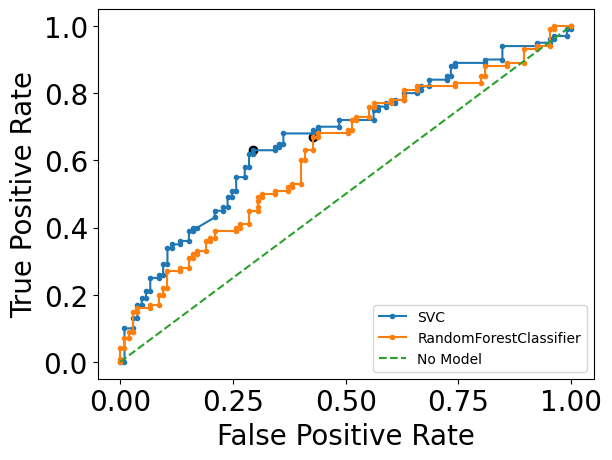

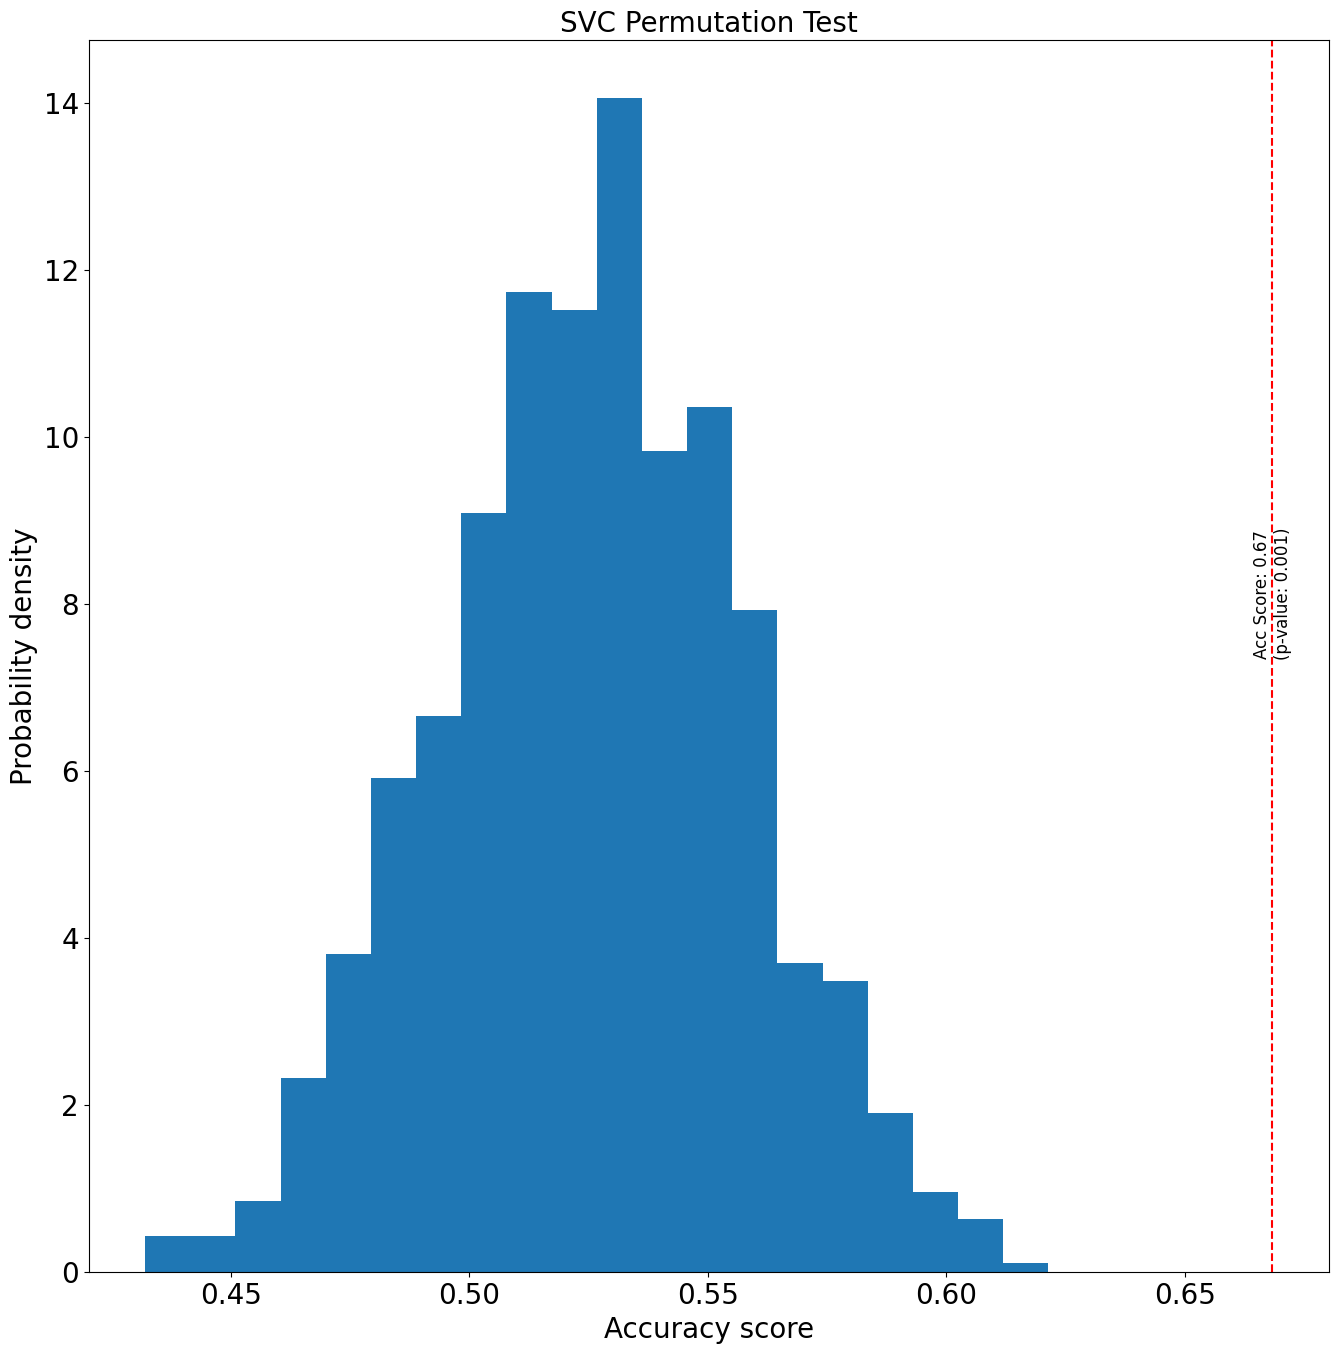

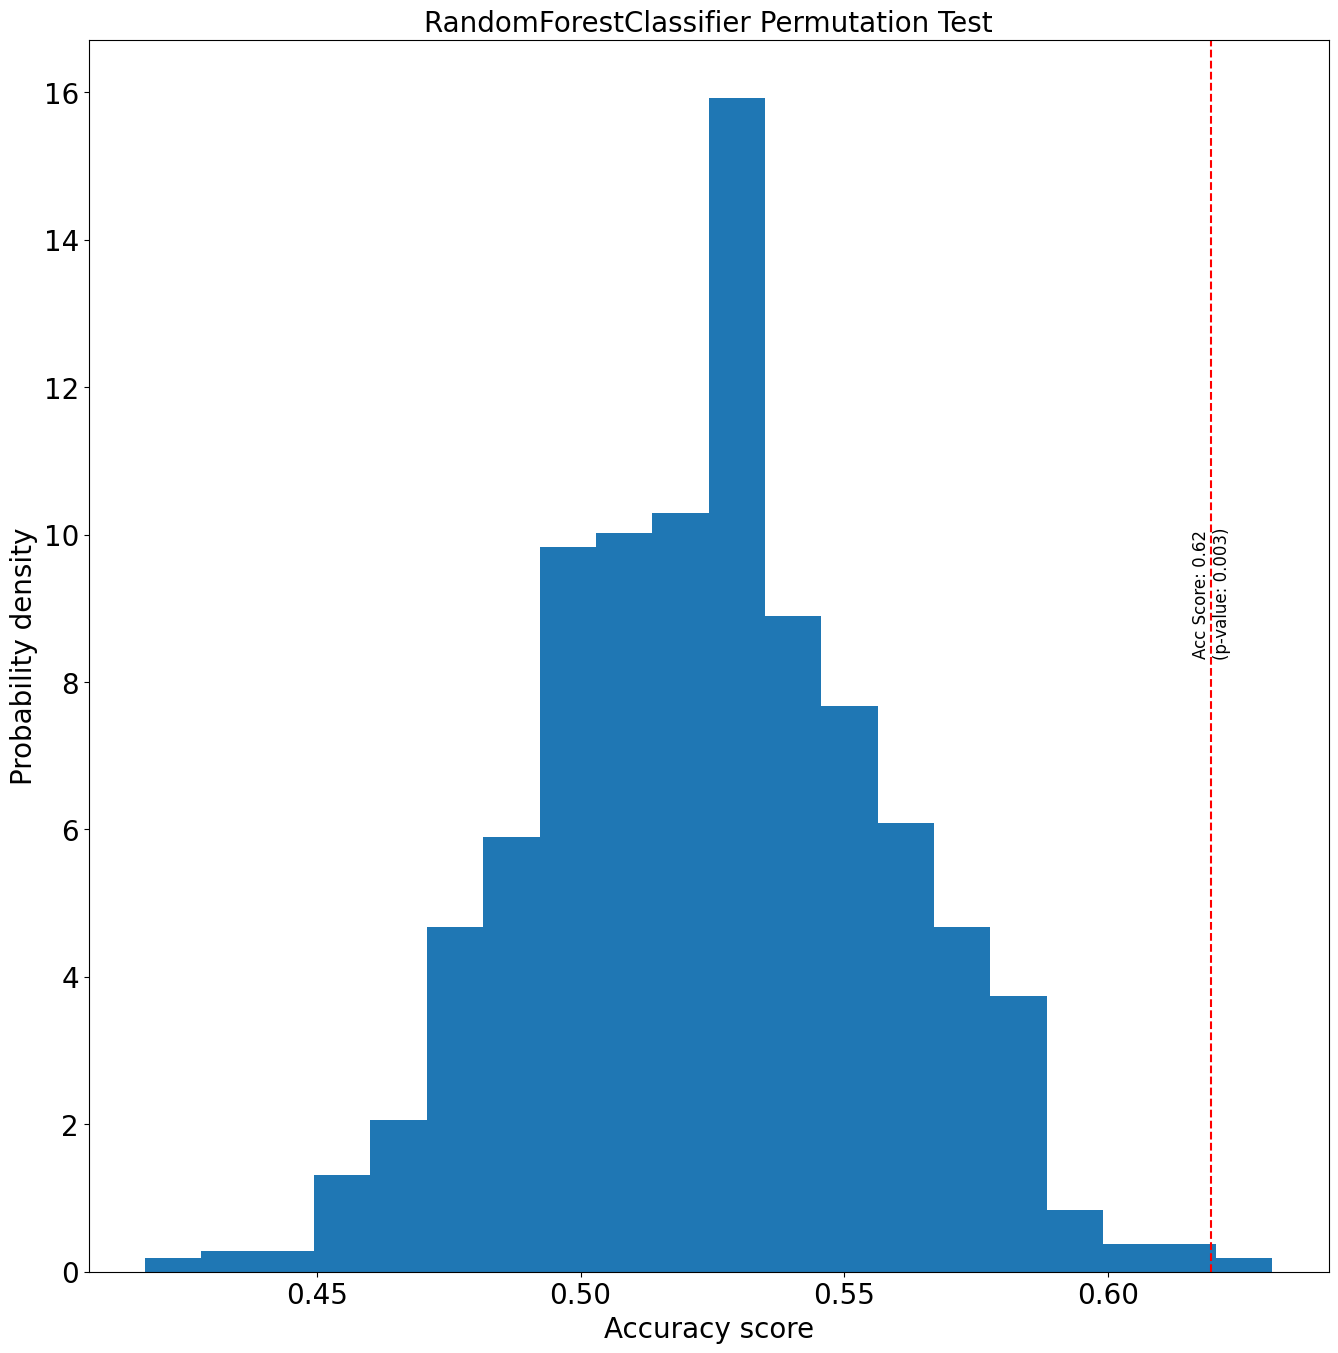

In [ ]:
# qc and combat (account for cov)
classifiers(train_val_latent_X, test_latent_X, train_val_latent_y, test_latent_y, K = 5, save=1, perm_test=1) # SVM and Random forest, CV folder=5

==== clf:  SVC 
 best parameter:  {'C': 50, 'gamma': 1, 'kernel': 'linear', 'probability': True} 
 best auc:  0.6169496125608978
Best Threshold=0.450665, G-Mean=0.666
test sensitivity after thres tuning:  0.63
test specificity after thres tuning:  0.7047619047619047
 test acc after thres tuning:  0.6682926829268293
 test auc after thres tuning:  0.6698095238095237
==== clf:  RandomForestClassifier 
 best parameter:  {'criterion': 'entropy', 'max_depth': 3, 'n_estimators': 50} 
 best auc:  0.6295525790823595
Best Threshold=0.470124, G-Mean=0.624
test sensitivity after thres tuning:  0.66
test specificity after thres tuning:  0.5904761904761905
 test acc after thres tuning:  0.624390243902439
 test auc after thres tuning:  0.6339047619047619


{'SVC': 0.6682926829268293, 'RandomForestClassifier': 0.624390243902439}

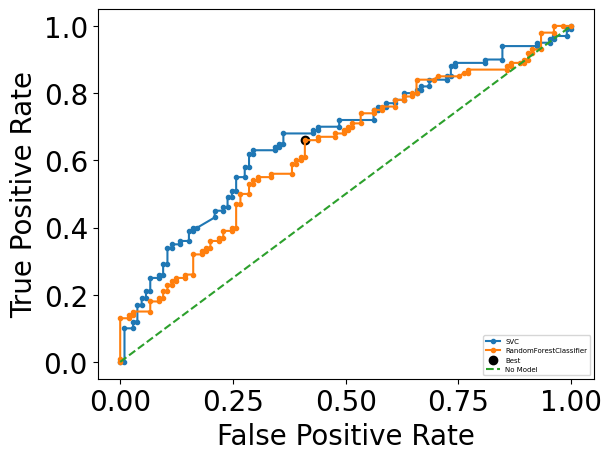

In [ ]:
# qc and combat (account for cov)
classifiers(train_val_latent_X, test_latent_X, train_val_latent_y, test_latent_y, K = 5) # SVM and Random forest, CV folder=5

In [ ]:
train_sex = np.array(train_covars['SEX_M'])
val_sex = np.array(val_covars['SEX_M'])
test_sex = np.array(test_covars['SEX_M'])

train_age = np.array(train_covars['AGE'])
val_age = np.array(val_covars['AGE'])
test_age = np.array(test_covars['AGE'])

In [ ]:
# add sex as a feature on the top of the latent variables
train_val_latent_sex_X = np.hstack((train_val_latent_X, np.concatenate((train_sex,val_sex)).reshape(-1,1)) )
test_latent_sex_X = np.hstack((test_latent_X, test_sex.reshape(-1,1) ))
# add age as a feature
train_val_latent_age_X = np.hstack((train_val_latent_X, np.concatenate((train_age,val_age)).reshape(-1,1)) )
test_latent_age_X = np.hstack((test_latent_X, test_age.reshape(-1,1)))
# add both age and sex as features
train_val_latent_age_sex_X = np.hstack((train_val_latent_X,
                                        np.concatenate((train_sex,val_sex)).reshape(-1,1),
                                        np.concatenate((train_age,val_age)).reshape(-1,1)))
test_latent_age_sex_X = np.hstack((test_latent_X, test_sex.reshape(-1,1), test_age.reshape(-1,1)))

In [ ]:
# add sex as a feature on the top of the connectivity features
train_val_sex_X = np.hstack((np.vstack((train_data,val_data)), np.concatenate((train_sex,val_sex)).reshape(-1,1)))
test_sex_X = np.hstack((test_data, test_sex.reshape(-1,1) ))
# add age as a feature
train_val_age_X = np.hstack((np.vstack((train_data,val_data)), np.concatenate((train_age,val_age)).reshape(-1,1)))
test_age_X = np.hstack((test_data, test_age.reshape(-1,1)))
# add both age and sex as features
train_val_age_sex_X = np.hstack((np.vstack((train_data,val_data)),
                                        np.concatenate((train_sex,val_sex)).reshape(-1,1),
                                        np.concatenate((train_age,val_age)).reshape(-1,1)))
test_age_sex_X = np.hstack((test_data, test_sex.reshape(-1,1), test_age.reshape(-1,1)))

==== clf:  SVC 
 best parameter:  {'C': 50, 'gamma': 1, 'kernel': 'linear', 'probability': True} 
 best auc:  0.637750546214496
Best Threshold=0.462038, G-Mean=0.654
test sensitivity after thres tuning:  0.66
test specificity after thres tuning:  0.6476190476190475
 test acc after thres tuning:  0.6536585365853659
 test auc after thres tuning:  0.6968571428571428
==== clf:  RandomForestClassifier 
 best parameter:  {'criterion': 'entropy', 'max_depth': 3, 'n_estimators': 50} 
 best auc:  0.6405930668078004
Best Threshold=0.458335, G-Mean=0.629
test sensitivity after thres tuning:  0.63
test specificity after thres tuning:  0.6285714285714286
 test acc after thres tuning:  0.6292682926829268
 test auc after thres tuning:  0.651952380952381


{'SVC': 0.6536585365853659, 'RandomForestClassifier': 0.6292682926829268}

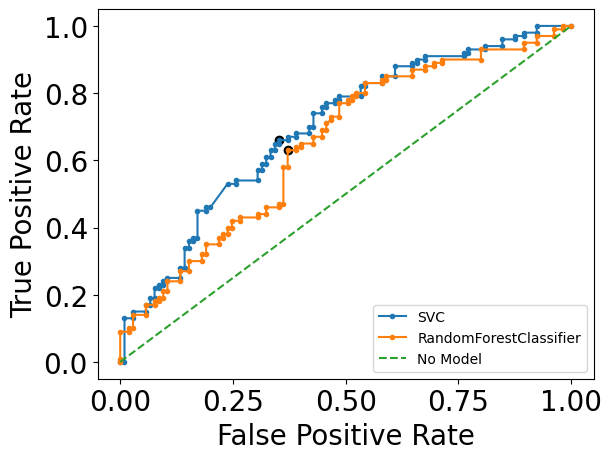

In [ ]:
classifiers(train_val_latent_age_sex_X, test_latent_age_sex_X, train_val_latent_y, test_latent_y, K = 5)

==== clf:  SVC 
 best parameter:  {'C': 50, 'gamma': 1, 'kernel': 'linear', 'probability': True} 
 best auc:  0.6249368969588404
Best Threshold=0.439952, G-Mean=0.654
test sensitivity after thres tuning:  0.69
test specificity after thres tuning:  0.6190476190476191
 test acc after thres tuning:  0.6536585365853659
 test auc after thres tuning:  0.6706666666666667
==== clf:  RandomForestClassifier 
 best parameter:  {'criterion': 'entropy', 'max_depth': 3, 'n_estimators': 50} 
 best auc:  0.6286706631926068
Best Threshold=0.443865, G-Mean=0.621
test sensitivity after thres tuning:  0.71
test specificity after thres tuning:  0.5428571428571429
 test acc after thres tuning:  0.624390243902439
 test auc after thres tuning:  0.6471904761904762


{'SVC': 0.6536585365853659, 'RandomForestClassifier': 0.624390243902439}

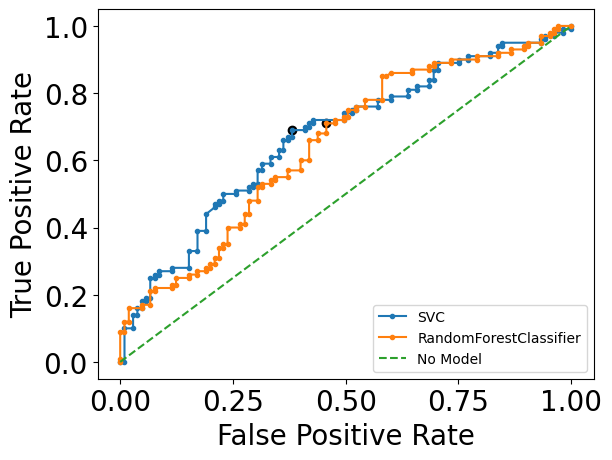

In [ ]:
classifiers(train_val_latent_age_X, test_latent_age_X, train_val_latent_y, test_latent_y, K = 5)

==== clf:  SVC 
 best parameter:  {'C': 50, 'gamma': 1, 'kernel': 'linear', 'probability': True} 
 best auc:  0.6292625086512234
Best Threshold=0.440933, G-Mean=0.658
test sensitivity after thres tuning:  0.7
test specificity after thres tuning:  0.6190476190476191
 test acc after thres tuning:  0.6585365853658537
 test auc after thres tuning:  0.6932380952380952
==== clf:  RandomForestClassifier 
 best parameter:  {'criterion': 'entropy', 'max_depth': 3, 'n_estimators': 50} 
 best auc:  0.629128329872844
Best Threshold=0.444858, G-Mean=0.627
test sensitivity after thres tuning:  0.7
test specificity after thres tuning:  0.5619047619047619
 test acc after thres tuning:  0.6292682926829268
 test auc after thres tuning:  0.6608095238095238


{'SVC': 0.6585365853658537, 'RandomForestClassifier': 0.6292682926829268}

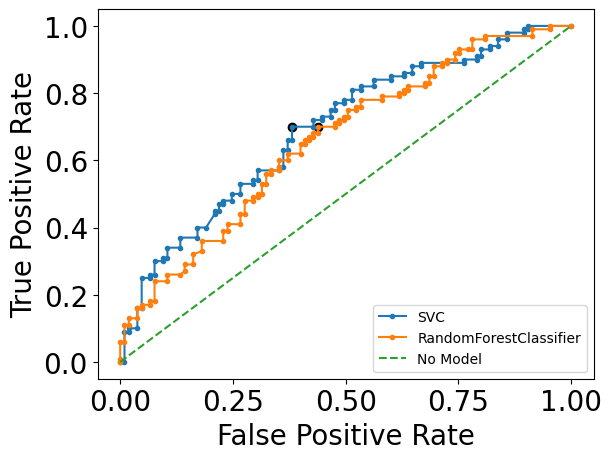

In [ ]:
classifiers(train_val_latent_sex_X, test_latent_sex_X, train_val_latent_y, test_latent_y, K = 5)

# LOSOCV

In [ ]:
import numpy as np
import pandas as pd
from torchvision import transforms

In [ ]:
# Leave one site out cross validation
atlas_want = 'power_2011'

# load preprocessed data (after qc without combat)
trainval_data = np.load(os.path.join('.','data', 'fmri', atlas_want+'_trainval_data_qc.npy'))
test_data = np.load(os.path.join('.','data', 'fmri', atlas_want+'_test_data_qc.npy'))
trainval_label = np.load(os.path.join('.','data','fmri', 'trainval_label_adj_qc.npy'))
test_label = np.load(os.path.join('.','data', 'fmri', 'test_label_adj_qc.npy'))
trainval_covars = pd.read_csv(os.path.join('.','data','fmri', 'trainval_covars_adj_qc.csv'))
test_covars = pd.read_csv(os.path.join('.','data','fmri', 'test_covars_adj_qc.csv'))

all_data = np.vstack((trainval_data, test_data))
all_label = np.concatenate((trainval_label, test_label))
all_site = np.concatenate((trainval_covars['SITE'], test_covars['SITE']))

In [ ]:
# for each qualified site (have more than 20 controls and 20 patients)
for site_ind in np.unique(all_site):
  if (sum(all_label[all_site == site_ind] == 1) > 20) & (sum(all_label[all_site == site_ind] == 0) > 20):
    print('==== SITE ',site_ind)

    train_data = all_data[all_site != site_ind,:]
    train_label = all_label[all_site != site_ind]
    val_data = all_data[all_site == site_ind,:]
    val_label = all_label[all_site == site_ind]

    trainset = np.hstack((train_data, train_label.reshape((train_data.shape[0],1))))
    train_dataset = PatientDataSet(pd.DataFrame(trainset))
    trans = transforms.Compose([GaussianNoise(0,0.1,train_dataset.data_columns),ToTorchFormat()])
    train_dataset.transform = trans

    valset = np.hstack((val_data, val_label.reshape((val_data.shape[0],1))))
    val_dataset = PatientDataSet(pd.DataFrame(valset))
    trans = transforms.Compose([GaussianNoise(0,0.1,val_dataset.data_columns),ToTorchFormat()])
    val_dataset.transform = trans

    atlas_want = 'power_2011'
    epochs = 1500
    hidden_size = 100
    latent_size = 5
    activations = ('tanh', 'selu', 'tanh', 'tanh')
    l2_rate = 0.1
    learning_rate = 1e-5
    net_name = '{}_combat{}_h{}_l{}_ep{}_site{}'.format(atlas_want, runCombat, hidden_size, latent_size, epochs, site_ind)
    stats_list = ["epoch", "loss", "loss_per_feature", "validation_loss", "validation_loss_per_feature"]

    train_net(net_name, train_dataset, num_epochs=epochs, until=epochs,
          hidden_size=hidden_size, latent_size=latent_size,
          activations=activations, l2=l2_rate, learning_rate=learning_rate,
          load_net=False, overwrite=True, overwrite_log=True,
          stats_list=stats_list, validation=[val_dataset])

    print(net_name)
    extract_latents(net_name, train_dataset, fname_tag='train')
    extract_latents(net_name, val_dataset, fname_tag='val')

In [ ]:
#  Run this cell only if models were already trained and saved
for site_ind in np.unique(all_site): # site_ind = 0
  if (sum(all_label[all_site == site_ind] == 1) > 20) & (sum(all_label[all_site == site_ind] == 0) > 20):
    print('==== SITE ',site_ind)

    atlas_want = 'power_2011'
    epochs = 1500
    hidden_size = 100
    latent_size = 5
    activations = ('tanh', 'selu', 'tanh', 'tanh')
    l2_rate = 0.1
    learning_rate = 1e-5
    net_name = '{}_combat{}_h{}_l{}_ep{}_site{}'.format(atlas_want, runCombat, hidden_size, latent_size, epochs, site_ind)
    stats_list = ["epoch", "loss", "loss_per_feature", "validation_loss", "validation_loss_per_feature"]

    train_latent_df = load_latents(net_name, fname_tag='train')
    val_latent_df = load_latents(net_name, fname_tag='val')
    label_col = ['0']
    data_cols = train_latent_df.columns[~train_latent_df.columns.isin(label_col)]
    train_latent_X = train_latent_df[data_cols].to_numpy()
    train_latent_y = train_latent_df[label_col].to_numpy().ravel()
    val_latent_X = val_latent_df[data_cols].to_numpy()
    val_latent_y = val_latent_df[label_col].to_numpy().ravel()

    train_val_latent_X = np.vstack((train_latent_X, val_latent_X))
    train_val_latent_y = np.concatenate((train_latent_y, val_latent_y))

    classifiers(train_latent_X, val_latent_X, train_latent_y, val_latent_y, K = 5)

# Boostrap CI

In [ ]:
from pandas import read_csv
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
def get_ci(stats, alpha = 0.95):

    p_lower = ((1.0-alpha)/2.0) * 100
    p_upper = (alpha+((1.0-alpha)/2.0)) * 100
    ci_lower = max(0.0, np.percentile(stats, p_lower))
    ci_upper = min(1.0, np.percentile(stats, p_upper))
    print('%.2f confidence interval: [%.4f , %.4f]' % (alpha, ci_lower, ci_upper))

    return(np.array([ci_lower, ci_upper]))

In [ ]:
def bootstrap_ml(data, label, n_iterations = 1000):

    RF_stats = list()
    SVC_stats = list()
    KNN_stats = list()

    for i in range(n_iterations):
        print('running iteration ',i)
        boot = np.random.choice(data.shape[0], data.shape[0])
        boot_data = data[boot,:]
        boot_label = label[boot]
        X_train, X_test, y_train, y_test = train_test_split(boot_data, boot_label,
                                                            test_size=0.2,
                                                            shuffle = True)
        # SVM
        model = SVC(C = 0.1,
                    gamma = 'auto', kernel = 'linear'
                    )
        model.fit(X_train, y_train)
        score = accuracy_score(y_test, model.predict(X_test))
        print('SVC:',score)
        SVC_stats.append(score)

        # RF
        model = RandomForestClassifier(n_estimators = 100, max_features = 'sqrt',
                                      max_depth = 5, criterion = 'gini',
                                      n_jobs = -1
                                      )
        model.fit(X_train, y_train)
        score = accuracy_score(y_test, model.predict(X_test))
        print('RF:',score)
        RF_stats.append(score)

        # KNN
        # model = KNeighborsClassifier(n_neighbors = 11,
        #                               weights = 'uniform',
        #                               algorithm = 'auto'
        #                               )
        # model.fit(X_train, y_train)
        # score = accuracy_score(y_test,  model.predict(X_test))
        # print('KNN:',score)
        # KNN_stats.append(score)

    return SVC_stats, RF_stats #, KNN_stats

In [ ]:
SVC_stats, RF_stats = bootstrap_ml(data = (train_latent_X)np.vstack((train_val_latent_X, test_latent_X)),
                                   label = np.concatenate((train_val_latent_y, test_latent_y)),
                                   n_iterations = 1000)

In [ ]:
get_ci(SVC_stats)

In [ ]:
get_ci(KNN_stats)

In [ ]:
get_ci(RF_stats)

# Permutation test

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold, permutation_test_score
from sklearn.svm import SVC
import matplotlib.pyplot as plt

best_param_SVC = load(os.path.join('ml_models', 'best_param_SVC'))
tuned_SVC = SVC(**best_param_SVC)
best_param_RandomForestClassifier= load(os.path.join('ml_models', 'best_param_RandomForestClassifier'))
tuned_RF = RandomForestClassifier(**best_param_RandomForestClassifier)

n_perm = 1000
cross_valid = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0)

def perm_test(model, X, y, n_perm):
    perm_acc = []
    for i in range(n_perm):
        np.random.shuffle(y)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        model.fit(X_train, y_train)
        pred_labels_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, thres = roc_curve(y_test, pred_labels_prob)
        gmeans = sqrt(tpr * (1-fpr))
        pred_labels_thres = (pred_labels_prob >= thres[argmax(gmeans)]).astype(bool)
        perm_acc.append(metrics.accuracy_score(pred_labels_thres, y_test))

    return perm_acc

def plot_perm_test(perm_acc, acc, n_perm, clf_name):
    pval = (sum(np.array(perm_acc) > acc) + 1) / (n_perm + 1)

    fig, ax = plt.subplots()
    ax.hist(perm_acc, bins=25, density=True)
    ax.axvline(acc, ls="--", color="r")
    ax.text(acc, ax.get_ylim()[1]/2, f"Acc Score: {acc:.2f}\n(p-value: {pval:.3f})", rotation=90, fontsize=12, horizontalalignment='center')
    ax.set_xlabel("Accuracy score")
    _ = ax.set_ylabel("Probability density")
    _ = ax.set_title(clf_name+' Permutation Test Result')
    plt.savefig(os.path.join('img',clf_name+'_perm_test.pdf'))
    plt.savefig(os.path.join('img',clf_name+'_perm_test.eps'))
    plt.show()

In [ ]:
perm_acc_SVC = perm_test(tuned_SVC, np.vstack((train_val_latent_X, test_latent_X)), np.hstack((train_val_latent_y, test_latent_y)), n_perm)
perm_acc_RF = perm_test(tuned_RF, np.vstack((train_val_latent_X, test_latent_X)), np.hstack((train_val_latent_y, test_latent_y)), n_perm)

np.save(os.path.join('img', 'perm_acc_SVC'), perm_acc_SVC)
np.save(os.path.join('img', 'perm_acc_RF'), perm_acc_RF)

In [ ]:
perm_acc_SVC = np.load(os.path.join('img', 'perm_acc_SVC.npy'))
perm_acc_RF = np.load(os.path.join('img', 'perm_acc_RF.npy'))

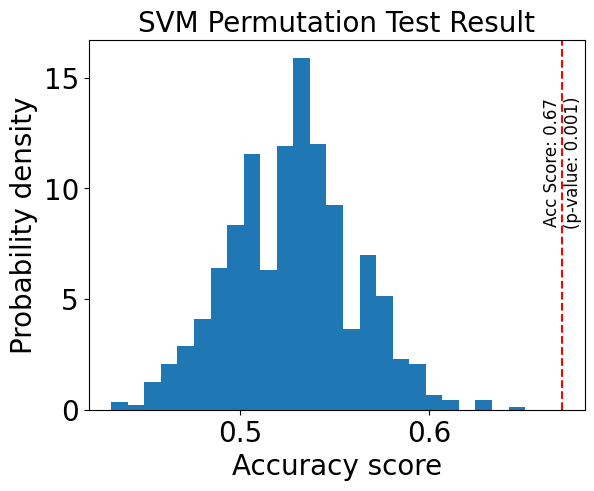

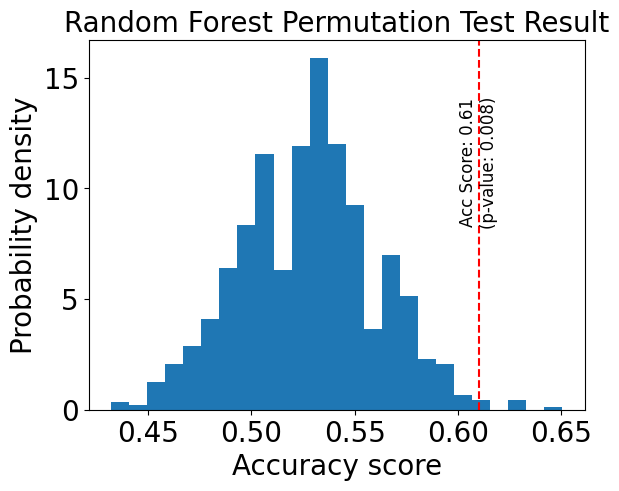

In [ ]:
plot_perm_test(perm_acc_SVC, 0.67, n_perm, 'SVM')
plot_perm_test(perm_acc_SVC, 0.61, n_perm, 'Random Forest')